<a href="https://colab.research.google.com/github/tiyasadey3/GEN_AI/blob/main/Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet torch torchvision transformers pillow crewai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/

In [2]:
!pip install -q langchain langchain_community langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.5/438.5 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.0 MB/s eta 0:00:00


In [3]:
!pip install colab-xterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 9.0 MB/s eta 0:00:00


In [4]:
%load_ext colabxterm

In [5]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [7]:
from crewai import Agent, Task, Crew
from crewai.process import Process
from langchain.llms import Ollama
from google.colab import files
from IPython.display import display
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

Saving picture.jpeg to picture (1).jpeg


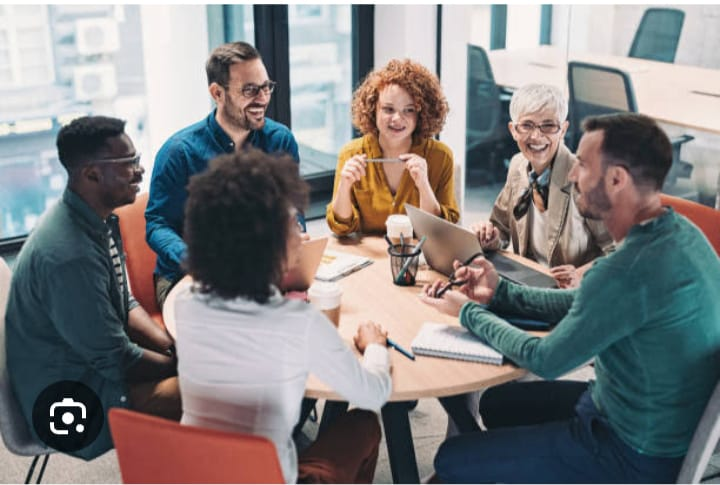

In [8]:
# Step 1: Upload and show the image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
img = Image.open('/content/picture.jpeg').convert('RGB')
display(img)

In [9]:
# Step 2: Use BLIP for real image understanding
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
inputs = processor(img, return_tensors="pt")
with torch.no_grad():
    out = model.generate(**inputs)
    blip_description = processor.decode(out[0], skip_special_tokens=True)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [10]:
print("BLIP Image Description:", blip_description)

BLIP Image Description: a group of people sitting around a table with a laptop


In [11]:
# Step 3: LLaMA 3 for caption, alt-text, etc.
llm = Ollama(model='ollama/llama3')

<ipython-input-11-bb552bc8d666>:2: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model='ollama/llama3')


In [12]:
# Agents
image_analyst = Agent(
    role="Image Analyst",
    goal="Expand the base description into a detailed analysis of color, mood, and composition",
    backstory="You are a visual analyst who interprets emotion and atmosphere in visual art.",
    llm=llm,
    allow_delegation=False,
    verbose=False
)

alt_text_writer = Agent(
    role="Alt-Text Writer",
    goal="Create clear, concise alt-text for accessibility tools",
    backstory="You're an accessibility specialist, excellent at writing compact, descriptive alt-text.",
    llm=llm,
    allow_delegation=False,
    verbose=False
)

caption_creator = Agent(
    role="Social Media Caption Wizard",
    goal="Write a fun, catchy caption for Instagram or Twitter based on the image description",
    backstory="You're a social media expert with a great sense of humor and trends.",
    llm=llm,
    allow_delegation=False,
    verbose=False
)

In [13]:
# Tasks (now based on BLIP's actual result)
analysis_task = Task(
    description=f"Based on this BLIP-generated summary of an image: '{blip_description}', analyze its visual tone, color, and mood.",
    agent=image_analyst,
    expected_output="Detailed aesthetic and emotional analysis of the image."
)

alt_text_task = Task(
    description=f"Write a short alt-text for screen readers based on the image: '{blip_description}'",
    agent=alt_text_writer,
    expected_output="Concise alt-text for the image."
)

caption_task = Task(
    description=f"Create an engaging caption for the image. Here's a description: '{blip_description}'",
    agent=caption_creator,
    expected_output="A creative social media caption."
)


In [14]:
# Crew
image_crew = Crew(
    agents=[image_analyst, alt_text_writer, caption_creator],
    tasks=[analysis_task, alt_text_task, caption_task],
    verbose=0,
    process=Process.sequential
)

In [15]:
# Run
result = image_crew.kickoff()
print(result)

"Table talk and Wi-Fi woes Don't worry, we're all in this digital journey together What's your favorite collaborative project or meeting moment? Share with us! #CollaborationGoals #DigitalMeetups #WorkAndPlay"
